# Dummy player VS Personalized player

Here we show a basic example of a 2-players simulation using the default player (a.k.a "dummy" player). The dummy player uses a set of hard-coded rules in the Player class, reproducing a somewhat "naive" behaviour. A dummy player always buys (when cash is sufficient), without following any particular strategy, nor looking at his opponent's situation.

Successively we provide a simple example to show how to modify the behaviour of a player, changing the class functions that determine how the player acts when falling in a particular cell. In particular, we will create a simple player that never buys brown roads.

In [1]:
import os

os.chdir('..')

from monosim.player import Player
from monosim.board import get_board, get_roads, get_properties, get_community_chest_cards, get_bank
import random
import pandas as pd
from scipy.stats import binom_test
from tqdm import tqdm

import seaborn as sns
sns.set()

## Dummy player

We run 10K simulations where at each iteration the seed of the random value is changed. This will modify the values of the dice used in each game, providing different games results. At the end of the simulation, we compare the number of times each player has won the game. We randomize which player starts first to further avoid bias in the results.

Note: We set a maximum number of turns equal to 1000 because there are situations in which the game doesn't end. This is possible in the game of Monopoly, though the number of times this happens might depend on the implementation as well. For now, we analyze results filtering out the occurrences where the game didn't end.

In [2]:
list_results = []

for seed in tqdm(range(0, 10000)):
    random.seed(seed)
    
    # ############## SET GAME (board, players, etc.) ##############
    bank = get_bank()
    dict_board = get_board()
    dict_roads = get_roads()
    dict_properties = get_properties()
    dict_community_chest_cards = get_community_chest_cards()
    community_cards_deck = list(dict_community_chest_cards.keys())
    player1 = Player('player1', 1, bank, dict_board, dict_roads, dict_properties, community_cards_deck)
    player2 = Player('player2', 2, bank, dict_board, dict_roads, dict_properties, community_cards_deck)
    
    player1.meet_other_players([player2])
    player2.meet_other_players([player1])

    list_players = [player1, player2]
    random.shuffle(list_players)  # Shuffle so that player1 doesn't always start first

    idx_count = 0
    while not player1.has_lost() and not player2.has_lost() and idx_count < 1000:
        for player in list_players:
            player.play()
        idx_count += 1
    if player1.has_lost():
        list_results.append((seed, 'player1_lost', list_players[0]._name))
    elif player2.has_lost():
        list_results.append((seed, 'player2_lost', list_players[0]._name))
    else:
        list_results.append((seed, 'nobody_lost', list_players[0]._name))

100%|██████████| 10000/10000 [00:31<00:00, 317.68it/s]


In [3]:
df_res = pd.DataFrame(list_results, columns=['seed', 'lost_player', 'starting_player'])
n_lost_p1 = df_res[df_res.lost_player == 'player1_lost'].shape[0]
n_lost_p2 = df_res[df_res.lost_player == 'player2_lost'].shape[0]
count_start_p1 = df_res[(df_res.starting_player == 'player1') & (df_res.lost_player != 'nobody_lost')].shape[0]
count_start_p2 = df_res[(df_res.starting_player == 'player2') & (df_res.lost_player != 'nobody_lost')].shape[0]

print('player 1 started {} times and lost {} times'.format(count_start_p1, n_lost_p1))
print('player 2 started {} times and lost {} times'.format(count_start_p2, n_lost_p2))
print('nobody lost {} times'.format(df_res[df_res.lost_player == 'nobody_lost'].shape[0]))

player 1 started 4320 times and lost 4272 times
player 2 started 4359 times and lost 4407 times
nobody lost 1321 times


To assess whether one player is stronger than the other one, we run a binobial test. The Null hyphosis is there player 1 is as good as player 2, which can also be espressed as: "Player 1 wins 50% of the times". The previous statement must be true also for Player 2, hence a two sided binomial test is run. It can be noticed that the p-value of the test is > 0.05, hence we're not able to reject the null hypothesis. This means that we cannot prove statistically that Player 1 > Player 2 (or viceversa), so we continue assuming that Player 1 and Player 2 are equally strong.

So far this makes sense considering that the implementation for Player 1 and 2 is identical.

In [6]:
binom_test(x=n_lost_p1, n=n_lost_p1+n_lost_p2, p=1/2, alternative='two-sided')

0.15032553580484911

To further illustrate that the two players are equally strong, we plot the number of times each player has won the game after N games. The blue and orange lines represent the number of times that player 1 and 2 won respectively. It can be notice how the two lines overlap through time.

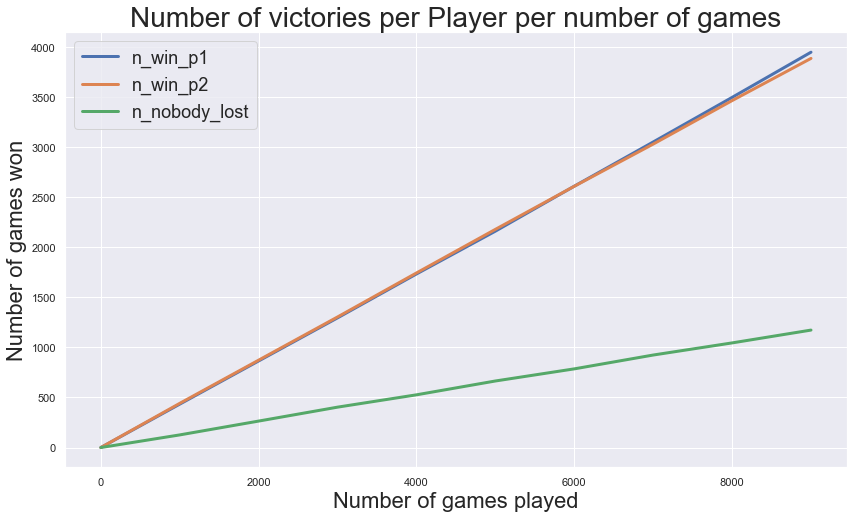

In [7]:
list_agg = []

for seed in range(0, 10000, 1000):
    df_tmp = df_res.iloc[:seed]
    n_win_p1 = df_tmp[df_tmp.lost_player == 'player2_lost'].shape[0]
    n_win_p2 = df_tmp[df_tmp.lost_player == 'player1_lost'].shape[0]
    n_nobody_lost = df_tmp[df_tmp.lost_player == 'nobody_lost'].shape[0]
    list_agg.append((seed, n_win_p1, n_win_p2, n_nobody_lost))

df_agg = pd.DataFrame(list_agg, columns=['seed', 'n_win_p1', 'n_win_p2', 'n_nobody_lost'])
ax = df_agg.set_index('seed').plot(figsize=(14, 8), linewidth=3)
ax.set_title('Number of victories per Player per number of games', fontsize=28)
ax.set_xlabel('Number of games played', fontsize=22)
ax.set_ylabel('Number of games won', fontsize=22)
ax.legend(fontsize=18)

fig = ax.get_figure()
fig.savefig('images/dummy_vs_dummy.png')

## No-brown player

Here we modify the behaviour of one of the two players. In particular, one of the two players will never buy brown roads. To change the player's behaviour we modify the function buy(), responsible for buying roads. The are several ways to modify the Player methods:

1. Use Decorators
1. Inherit new class from class Player, modifying the methods
3. Use types.MethodType


Here we use the first approach, which is the most concise, however the other solutions are shown at the end of the notebook. We decorate the function buy(), adding an initial check, which avoids a road acquisition if the color is brown. The new decorated class is called Player_no_brown.

In [8]:
# from https://stackoverflow.com/questions/24768400/how-would-one-decorate-an-inherited-method-in-the-child-class
def modify_buy(buy):
    def _wrapper(self, dict_road_info, road_name):
        if dict_road_info['color'] == 'brown':
            pass
        else:
            buy(self, dict_road_info, road_name)
    return _wrapper

class Player_no_brown(Player):
    buy = modify_buy(Player.buy)

In [9]:
list_results = []

for seed in tqdm(range(0, 10000)):
    random.seed(seed)
    bank = get_bank()
    dict_board = get_board()
    dict_roads = get_roads()
    dict_properties = get_properties()
    dict_community_chest_cards = get_community_chest_cards()
    community_cards_deck = list(dict_community_chest_cards.keys())
    player1 = Player_no_brown('player1', 1, bank, dict_board, dict_roads, dict_properties, community_cards_deck)
    player2 = Player('player2', 2, bank, dict_board, dict_roads, dict_properties, community_cards_deck)

    player1.meet_other_players([player2])
    player2.meet_other_players([player1])

    list_players = [player1, player2]
    random.shuffle(list_players)  # Shuffle so that player1 doesn't always start first

    idx_count = 0
    while not player1.has_lost() and not player2.has_lost() and idx_count < 1000:
        for player in list_players:
            player.play()
        idx_count += 1

    if player1.has_lost():
        list_results.append((seed, 'player1_lost', list_players[0]._name))
    elif player2.has_lost():
        list_results.append((seed, 'player2_lost', list_players[0]._name))
    else:
        list_results.append((seed, 'nobody_lost', list_players[0]._name))

100%|██████████| 10000/10000 [00:32<00:00, 310.18it/s]


In [10]:
df_res = pd.DataFrame(list_results, columns=['seed', 'lost_player', 'starting_player'])
n_lost_p1 = df_res[df_res.lost_player == 'player1_lost'].shape[0]
n_lost_p2 = df_res[df_res.lost_player == 'player2_lost'].shape[0]
count_start_p1 = df_res[(df_res.starting_player == 'player1') & (df_res.lost_player != 'nobody_lost')].shape[0]
count_start_p2 = df_res[(df_res.starting_player == 'player2') & (df_res.lost_player != 'nobody_lost')].shape[0]

print('player 1 started {} times and lost {} times'.format(count_start_p1, n_lost_p1))
print('player 2 started {} times and lost {} times'.format(count_start_p2, n_lost_p2))
print('nobody lost {} times'.format(df_res[df_res.lost_player == 'nobody_lost'].shape[0]))

player 1 started 4336 times and lost 4678 times
player 2 started 4362 times and lost 4020 times
nobody lost 1302 times


In this case the p-value of the binomial test is lower than 0.05, so we reject the null hypothesis. This means that the two players are not equally good, in particular, Player 2 is stronger than Player 1.

In [11]:
binom_test(x=n_lost_p1, n=n_lost_p1+n_lost_p2, p=1/2, alternative='two-sided')

1.8166707613709124e-12

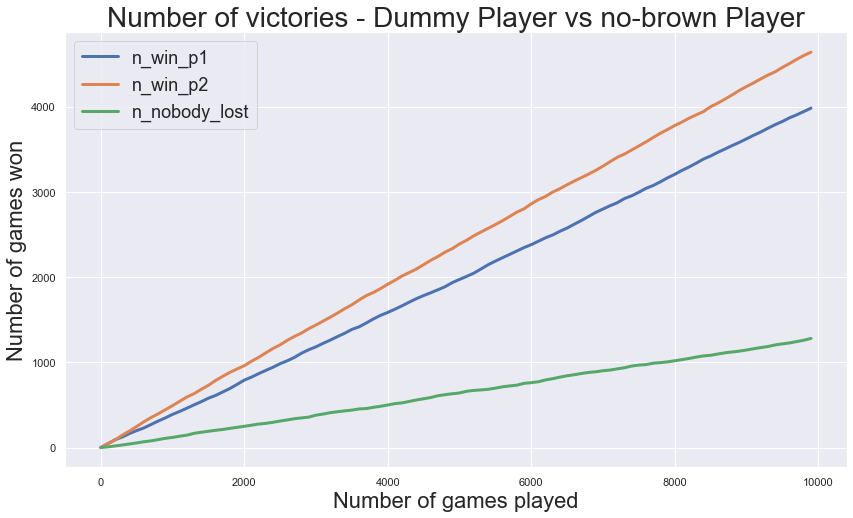

In [12]:
list_agg = []

for seed in range(0, 10000, 100):
    df_tmp = df_res.iloc[:seed]
    n_win_p1 = df_tmp[df_tmp.lost_player == 'player2_lost'].shape[0]
    n_win_p2 = df_tmp[df_tmp.lost_player == 'player1_lost'].shape[0]
    n_nobody_lost = df_tmp[df_tmp.lost_player == 'nobody_lost'].shape[0]
    list_agg.append((seed, n_win_p1, n_win_p2, n_nobody_lost))

df_agg = pd.DataFrame(list_agg, columns=['seed', 'n_win_p1', 'n_win_p2', 'n_nobody_lost'])
ax = df_agg.set_index('seed').plot(figsize=(14, 8), linewidth=3)

ax.set_title('Number of victories - Dummy Player vs no-brown Player', fontsize=28)
ax.set_xlabel('Number of games played', fontsize=22)
ax.set_ylabel('Number of games won', fontsize=22)
ax.legend(fontsize=18)

fig = ax.get_figure()
fig.savefig('images/dummy_vs_no_brown.png')

# Appendices

### Appendix A (change class Player methods behaviours)

Here we show to alternative approaches to change players' behavior, modifying the Player class methods.

#### **Inherit new class**

The class Player_no_brown is inherited from the class player, and the function buy() is copied, adding a special case for when the player ends in a road with color "brown". Alternatively, the function buy_or_bid() can be modified, to return "bid" instead of "buy" when the property has color="brown". (NOTE: this would be a hack as the bid() function has not been inplemented yet, so it's not a suggested solution).

In [13]:
class Player_no_brown(Player):
    def buy(self, dict_road_info, road_name):
        """ Buy road

        :param dict_road_info: (dictionary) Road information
        :param road_name: (String) Road name
        :return:
        """

        if dict_road_info['color'] == 'brown':
            pass
        else:
            road_price = dict_road_info['price']
            # enough money?
            if self._cash < road_price:
                raise Exception('Player {} does not have enough money'.format(self._name))
            # pay bank
            self._bank['cash'] += road_price
            self._cash -= road_price
            # exchange ownership
            dict_road_info['belongs_to'] = self._name
            self._list_owned_roads.append(road_name)
            self._dict_owned_houses_hotels[road_name] = (0, 0)
            # mortgage value
            self._properties_total_mortgageable_amount += dict_road_info['mortgage_value']

            color = dict_road_info['color']
            count_roads_of_color = 0
            for road in self._list_owned_roads:
                if color == self._dict_roads[road]['color']:
                    count_roads_of_color += 1
            if color == 'brown' and count_roads_of_color == 2:
                self._dict_owned_colors[color] = True
            elif color == 'light_blue' and count_roads_of_color == 3:
                self._dict_owned_colors[color] = True
            elif color == 'purple' and count_roads_of_color == 3:
                self._dict_owned_colors[color] = True
            elif color == 'orange' and count_roads_of_color == 3:
                self._dict_owned_colors[color] = True
            elif color == 'red' and count_roads_of_color == 3:
                self._dict_owned_colors[color] = True
            elif color == 'yellow' and count_roads_of_color == 3:
                self._dict_owned_colors[color] = True
            elif color == 'green' and count_roads_of_color == 3:
                self._dict_owned_colors[color] = True
            elif color == 'blue' and count_roads_of_color == 2:
                self._dict_owned_colors[color] = True

#### **Use types.MethodType**

Using the library types, we can substitute an object method using the function MethodType. See example below.

In [14]:
import types

def buy_new(self, dict_road_info, road_name):
    """ Buy road

    :param dict_road_info: (dictionary) Road information
    :param road_name: (String) Road name
    :return:
    """
    
    if dict_road_info['color'] == 'brown':
        pass
    else:
        road_price = dict_road_info['price']
        # enough money?
        if self._cash < road_price:
            raise Exception('Player {} does not have enough money'.format(self._name))
        # pay bank
        self._bank['cash'] += road_price
        self._cash -= road_price
        # exchange ownership
        dict_road_info['belongs_to'] = self._name
        self._list_owned_roads.append(road_name)
        self._dict_owned_houses_hotels[road_name] = (0, 0)
        # mortgage value
        self._properties_total_mortgageable_amount += dict_road_info['mortgage_value']

        color = dict_road_info['color']
        count_roads_of_color = 0
        for road in self._list_owned_roads:
            if color == self._dict_roads[road]['color']:
                count_roads_of_color += 1
        if color == 'brown' and count_roads_of_color == 2:
            self._dict_owned_colors[color] = True
        elif color == 'light_blue' and count_roads_of_color == 3:
            self._dict_owned_colors[color] = True
        elif color == 'purple' and count_roads_of_color == 3:
            self._dict_owned_colors[color] = True
        elif color == 'orange' and count_roads_of_color == 3:
            self._dict_owned_colors[color] = True
        elif color == 'red' and count_roads_of_color == 3:
            self._dict_owned_colors[color] = True
        elif color == 'yellow' and count_roads_of_color == 3:
            self._dict_owned_colors[color] = True
        elif color == 'green' and count_roads_of_color == 3:
            self._dict_owned_colors[color] = True
        elif color == 'blue' and count_roads_of_color == 2:
            self._dict_owned_colors[color] = True

In [15]:
list_results = []

for seed in tqdm(range(0, 10000)):
    random.seed(seed)
    bank = get_bank()
    dict_board = get_board()
    dict_roads = get_roads()
    dict_properties = get_properties()
    dict_community_chest_cards = get_community_chest_cards()
    community_cards_deck = list(dict_community_chest_cards.keys())
    player1 = Player('player1', 1, bank, dict_board, dict_roads, dict_properties, community_cards_deck)
    player2 = Player('player2', 2, bank, dict_board, dict_roads, dict_properties, community_cards_deck)
    
    player1.buy = types.MethodType(buy_new, player1)

    player1.meet_other_players([player2])
    player2.meet_other_players([player1])

    list_players = [player1, player2]
    random.shuffle(list_players)  # Shuffle so that player1 doesn't always start first

    idx_count = 0
    while not player1.has_lost() and not player2.has_lost() and idx_count < 1000:
        for player in list_players:
            player.play()
        idx_count += 1

    if player1.has_lost():
        list_results.append((seed, 'player1_lost', list_players[0]._name))
    elif player2.has_lost():
        list_results.append((seed, 'player2_lost', list_players[0]._name))
    else:
        list_results.append((seed, 'nobody_lost', list_players[0]._name))

100%|██████████| 10000/10000 [00:32<00:00, 312.35it/s]
